In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

Linearized least squares problem with exponential growth model

## Part a

c1: 7.122, c2: -0.184


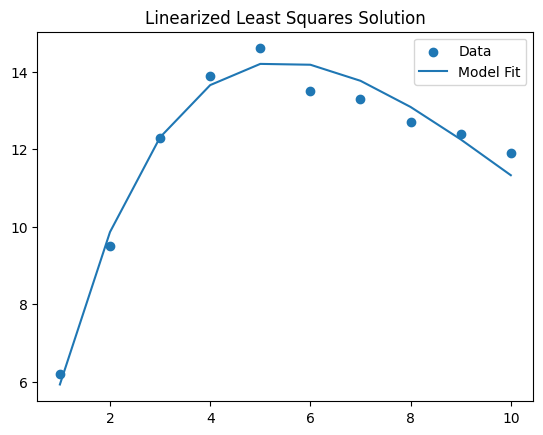

In [2]:
from numpy import log, exp

# Estabish data vectors
t = np.arange(1,11, dtype=np.float64).T
y = np.array([6.2, 9.5, 12.3, 13.9, 14.6, 13.5, 13.3, 12.7, 12.4, 11.9]).T

# Define (linearized) least squares vectors
A = np.column_stack((np.ones(10, dtype=np.float64), t))
b_ = log(y) - log(t)

# Solve linearized least squares
c_ = np.linalg.solve(A.T @ A, A.T @ b_.T)
c = c_.copy()
c[0] = exp(c[0]) # Convert linearized solution to orginal form

print(f"c1: {round(c[0],3)}, c2: {round(c[1],3)}")

# Use fitted model to obtain predictions
y_pred = c[0]*t*exp(c[1]*t)

plt.scatter(t,y, label='Data')
plt.plot(t,y_pred, label='Model Fit')
plt.legend()
plt.title('Linearized Least Squares Solution')
plt.show()

## Part b

To approximate the max, we will take very small steps between 4 and 7 using our model.

In [3]:
t_ = np.linspace(4,7,1000)
vals = c[0]*t_*exp(c[1]*t_)
time_index_of_max = np.argmax(vals)

print(f"Approximate max dose: {round(np.max(vals),3)}")

Approximate max dose: 14.251


## Part c

We seek the approximate time for the drug to reach half of its initial (maxmimum dose), which in our case is 14.25/2 = 7.125:
  
$7.125 = c1*\bar t*e^{c2*\bar t}$

where c1 and c2 are known from above. We can reduce this expression to

$ln(7.125) - ln(c1) - ln(\bar t) - c2*\bar t=0$

In [4]:
from scipy.optimize import fsolve
f = lambda t: log(7.125) - log(c[0]) - log(t) - c[1]*t

# We set x0 = 10 to avoid the solution to this equation at
# 1.3 that corresponds to a time before the max dose is reached
total_half_life = fsolve(f, 10)[0]

half_life_from_peak = total_half_life - t_[time_index_of_max]

print(f"The half-life is approximately {round(half_life_from_peak,2)} hours")

The half-life is approximately 9.13 hours


## Part d

We seek to estimate the time that the drug is within theraputic levels (4 - 15 ng/ml). We must find the time between when it first hits 4 and when it later returns to 4 since we estimate it never passes 15. We use a similar equation to above: 
  
$ln(4) - ln(c1) - ln(\bar t) - c2*\bar t=0$
  
First, we set x0 (for the root finder) to be 0 to find the first time it passes 4, then we will set it to some later time that will be closer to the second time it hits 4.

In [5]:
f = lambda t: log(4) - log(c[0]) - log(t) - c[1]*t

first_hit = fsolve(f,1)[0]
second_hit = fsolve(f,10)[0]

active_time = second_hit - first_hit

print(f"Active time: {round(active_time,3)} hours")

Active time: 18.584 hours


# Question 2

Use of "manual" Gram-Schmidt to produce an orthogonal basis that spans the same set as a given list of vectors

## Part a

In [6]:
def proj(u,w):
    "Project w onto u"
    if np.all(u == 0):
        return 0
    return (np.dot(w, u) / np.dot(u, u)) * u


def gram_schmidt(w):
    [m,n] = w.shape
    u = np.zeros_like(w)

    # For all columns
    for j in range(n):
        # Initialze the orthogonal column
        u[:,j] = w[:,j].copy()
        # Subtract the projection of each previous column
        for i in range(j):
            u[:,j] -= proj(u[:,i], w[:,j])

    return u


w1 = np.array([1., -1., 1., -1.])
w2 = np.array([1., 1. , 3., -1.])
w3 = np.array([-3., 7., 1., 3.])

u = gram_schmidt(np.column_stack([w1,w2,w3]))
print(u.round(3))

[[ 1.  0.  0.]
 [-1.  2.  0.]
 [ 1.  2.  0.]
 [-1.  0.  0.]]


The last vector is zero since the given vectors, $w_1, w_2, w_3$ are linearly dependent.

## Part b

To check if the resulting vectors are in fact orthogonal, we see if the dot product of all three equals zero.

In [7]:
print(np.dot(u[:,0], u[:,1]))
print(np.dot(u[:,0], u[:,2]))
print(np.dot(u[:,1], u[:,2]))

0.0
0.0
0.0


Typically we expect $u^Tu$ to be a diagonal matrix, but since the vectors are not linearly independent, we don't get this exactly and there is one zero on the diagonal. Also, the diagonal entries are not 1 since we did not normalize.

In [8]:
print(u.T @ u)

[[4. 0. 0.]
 [0. 8. 0.]
 [0. 0. 0.]]


# Question 3

Comparison of Classical vs Modified Gram-Schmidt for QR factorization

### Classical Gram-Schmidt

In [9]:
def classic_gram_schmidt(A):
    [m,n] = A.shape
    Q = np.zeros((m,n), dtype=np.float64)
    R = np.zeros((n,n), dtype=np.float64)

    # Classical Gram-Schmidt algorithm
    for j in range(n):
        # Initialize orthogonal vector
        y = A[:,j]
        # Subtract projection of previous vectors
        for i in range(j):
            R[i,j] = Q[:,i].T @ A[:,j]
            y -= R[i,j] * Q[:,i]
        # Set diagonal component of R and obtain normalized
        # orthogonal vector
        R[j,j] = np.linalg.norm(y)
        Q[:,j] = y / R[j,j]

    return Q, R

### Modified Gram-Schmidt

In [10]:
def modified_gram_schmidt(A):
    [m,n] = A.shape
    Q = np.zeros((m,n), dtype=np.float64)
    R = np.zeros((n,n), dtype=np.float64)

    # Modified Gram-Schmidt algorithm
    for j in range(n):
        y = A[:,j]
        for i in range(j):
            R[i,j] = Q[:,i].T @ y # Here we instead subtract projection of the most recent saved version to improve accuracy
            y -= R[i,j] * Q[:,i]
        R[j,j] = np.linalg.norm(y)
        Q[:,j] = y / R[j,j]

    return Q, R

In [11]:
delta = 10e-10

w1 = np.array([1., delta, delta/2, delta/3])
w2 = np.array([1., delta/2, delta/3, delta/4])
w3 = np.array([1., delta/3, delta/4, delta/5])

A = np.column_stack([w1,w2,w3])

Q_classic = classic_gram_schmidt(A)[0]
Q_modified = modified_gram_schmidt(A)[0]

If Q is in fact perfectly orthogonal, we expect $Q^T*Q$ to yield to identity matrix, but we suspect it will not be exact since we used such small values.

In [12]:
# Check accuracy
print(f"Q^T * Q (classic):\n {Q_classic.T @ Q_classic}")
print('')
print(f"Q^T * Q (modified):\n {Q_modified.T @ Q_modified}")

Q^T * Q (classic):
 [[ 1.00000000e+00 -1.14527425e-09 -2.20872348e-10]
 [-1.14527425e-09  1.00000000e+00 -2.49475840e-15]
 [-2.20872348e-10 -2.49475840e-15  1.00000000e+00]]

Q^T * Q (modified):
 [[ 1.00000000e+00 -2.63539188e-27  3.72078702e-27]
 [-2.63539188e-27  1.00000000e+00 -2.45460252e-17]
 [ 3.72078702e-27 -2.45460252e-17  1.00000000e+00]]


We see significantly more accuracy from modified Gram-Schmidt.

# Question 4

QR factorization to solve least squares

In [13]:
def full_QR(A):
    # Pad matrix A to add identity to extra k = m-n columns
    [m,n] = A.shape
    A_ = np.eye(m, dtype=np.float64)
    A_[:,:n] = A

    Q, R_ = modified_gram_schmidt(A_)

    # R is mxm but we only want nxn part
    R = R_[:n,:n].copy()

    return Q, R

w1 = np.array([1.,-1.,1.,1.])
w2 = np.array([4.,1.,1.,0.])
A = np.column_stack((w1,w2))

print(A)
Q, R_hat = full_QR(A)

[[ 1.  4.]
 [-1.  1.]
 [ 1.  1.]
 [ 1.  0.]]


To solve least squares, we solve $\hat Rx=\hat d$, where $\hat R$ is the upper $nxn$ block of $R$ from QR, and $\hat d$ is the first n entries from $d=Q^Tb$

In [14]:
# Define important vectors
b = np.array([3,1,1,-3])
d = Q.T @ b
n = R_hat.shape[0]
d_hat = d[:n].copy() # We only want the first n components

x = np.linalg.solve(R_hat,d_hat) # Solve Rx=d
y_pred = A @ x
x

array([-1.,  1.])

# Question 5

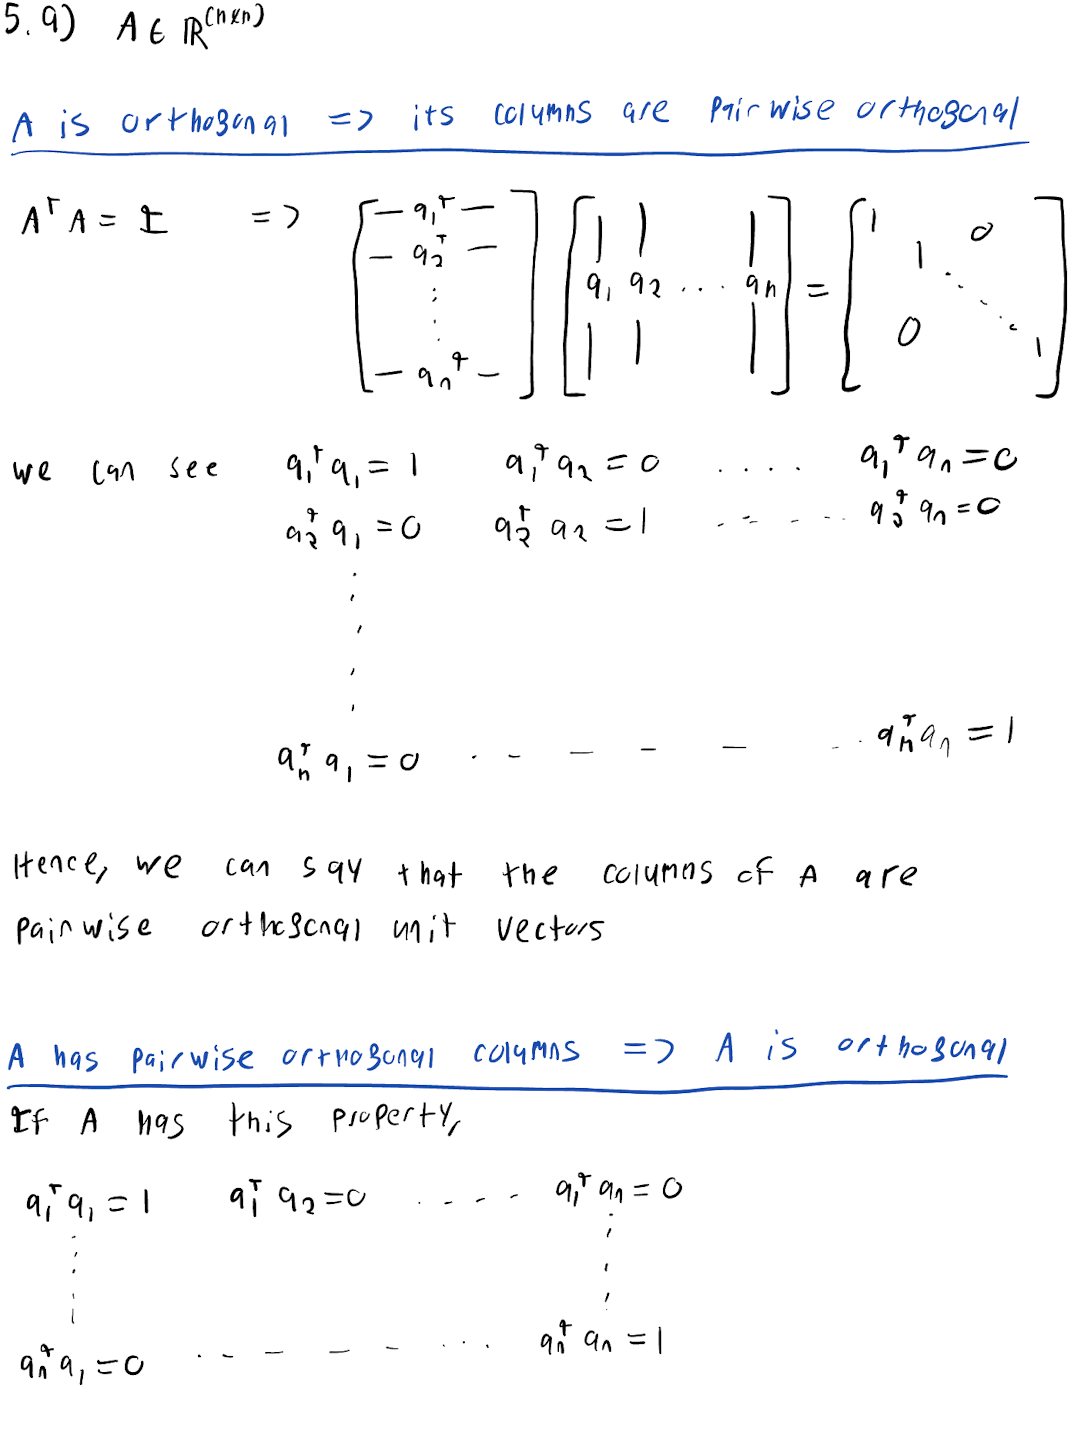

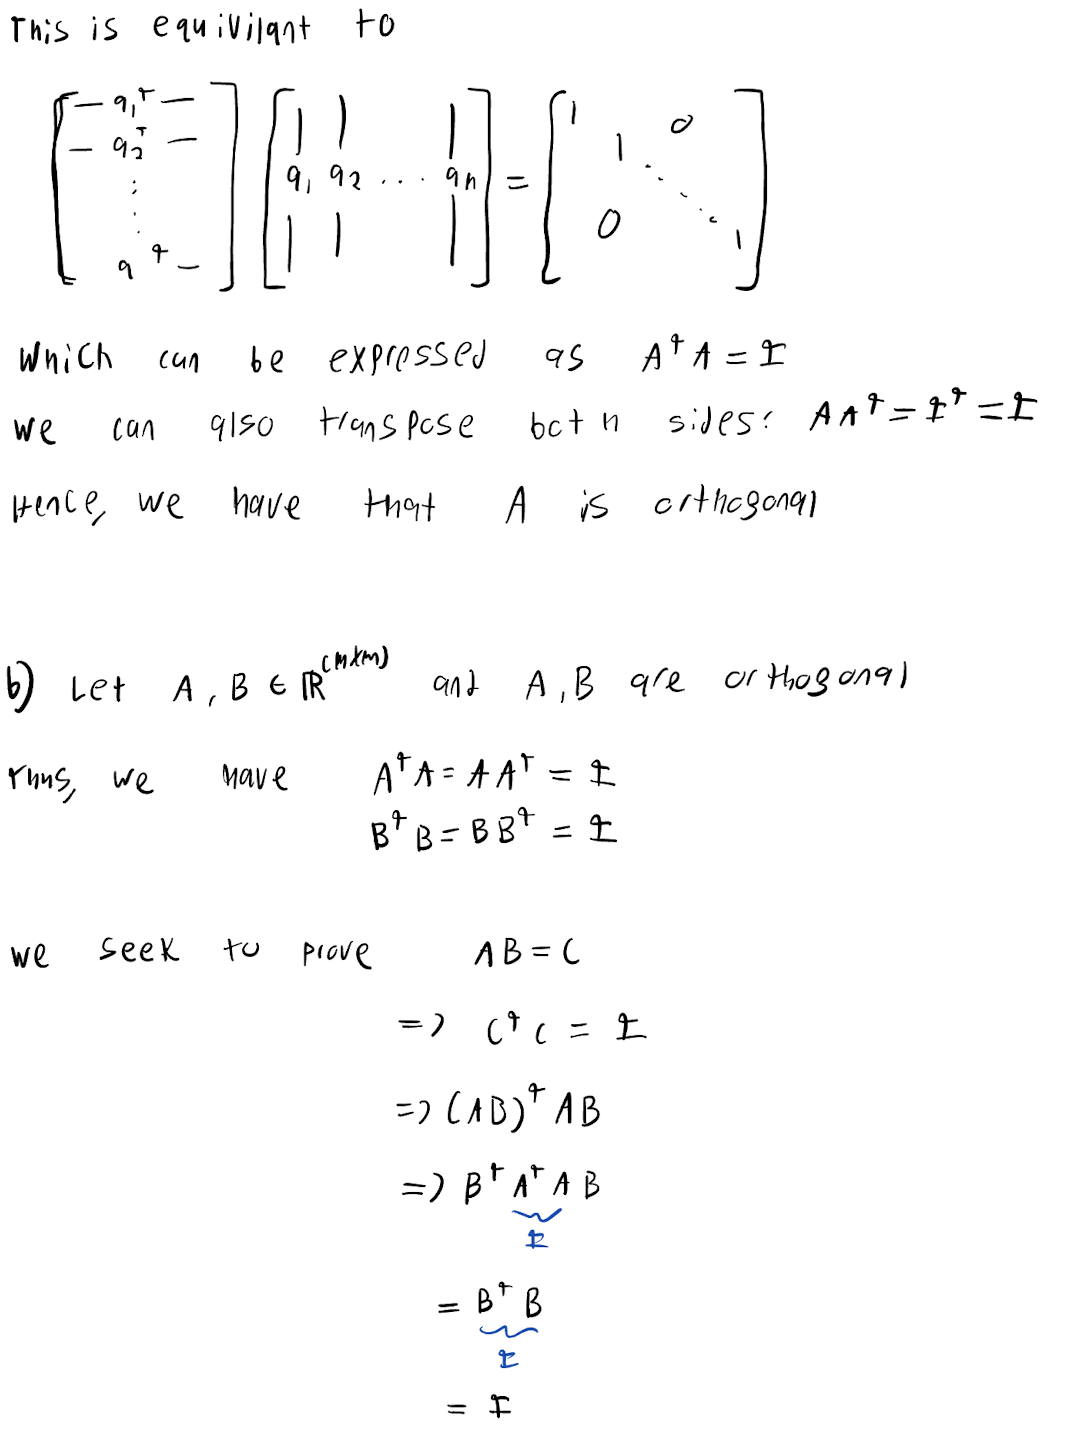

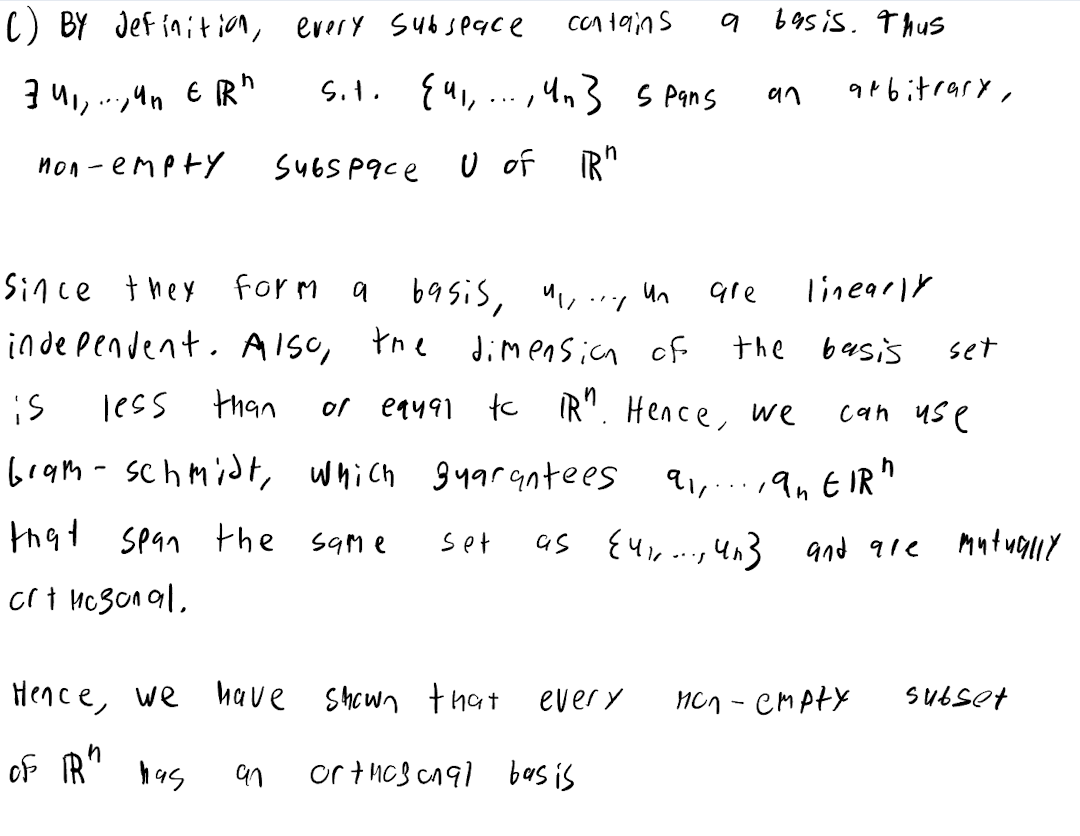

# Question 6

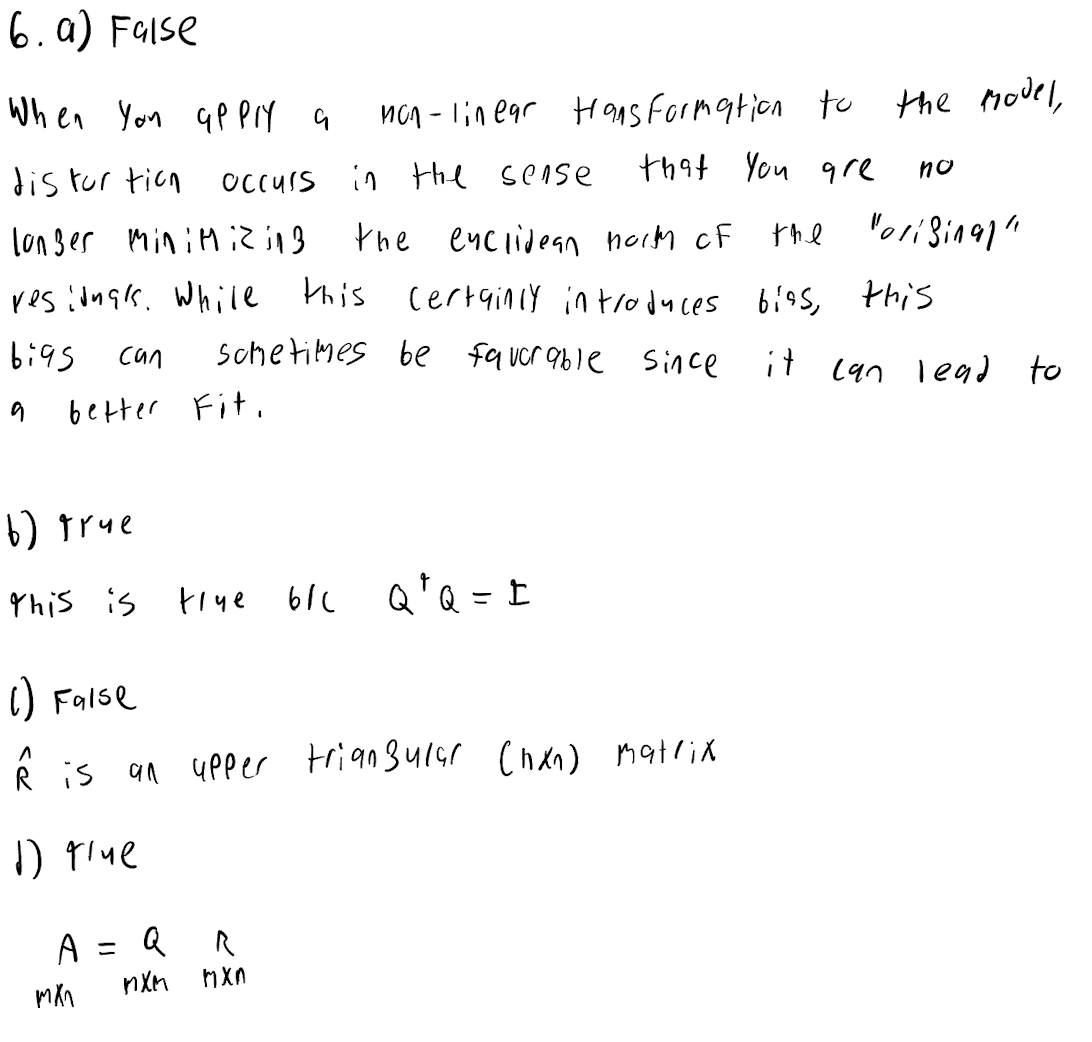

# Question 7

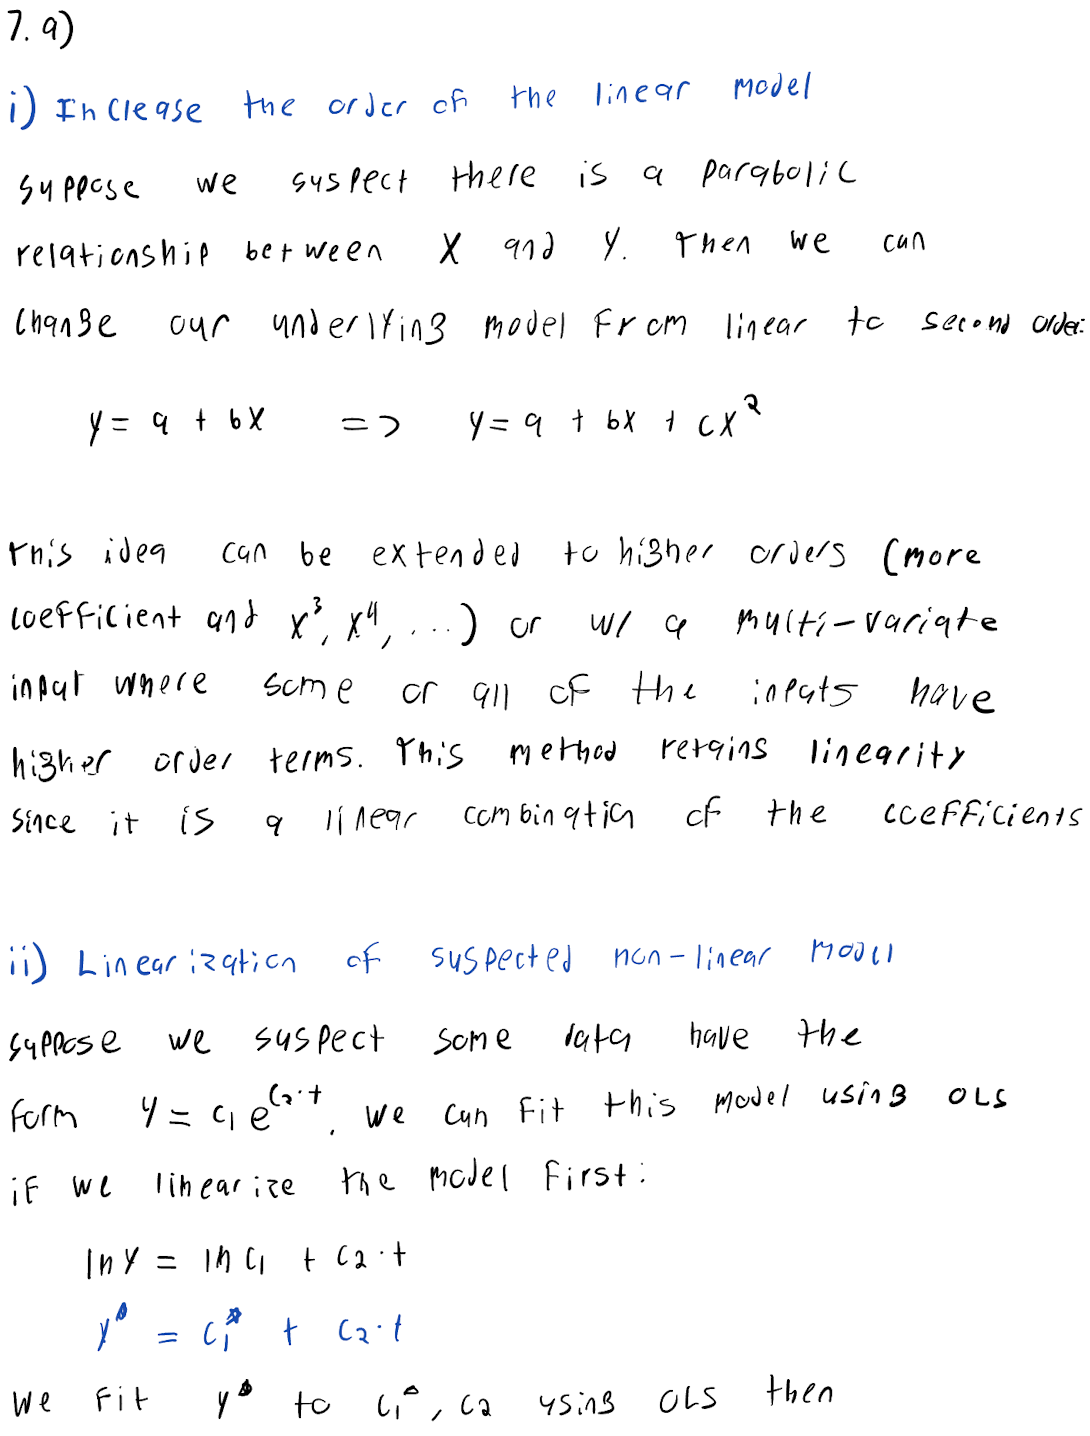

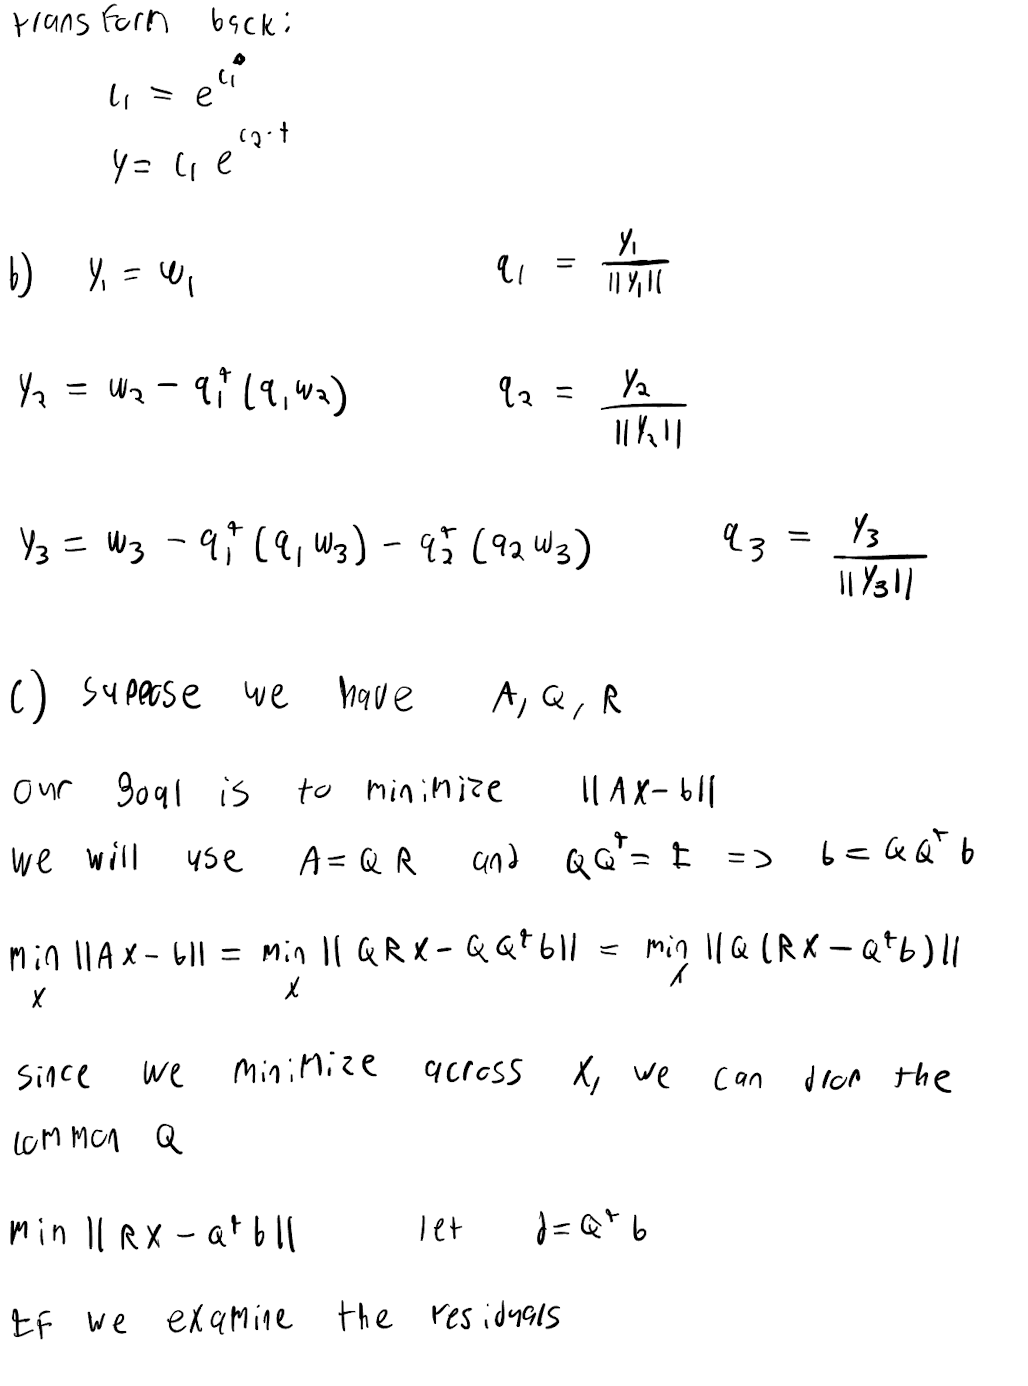

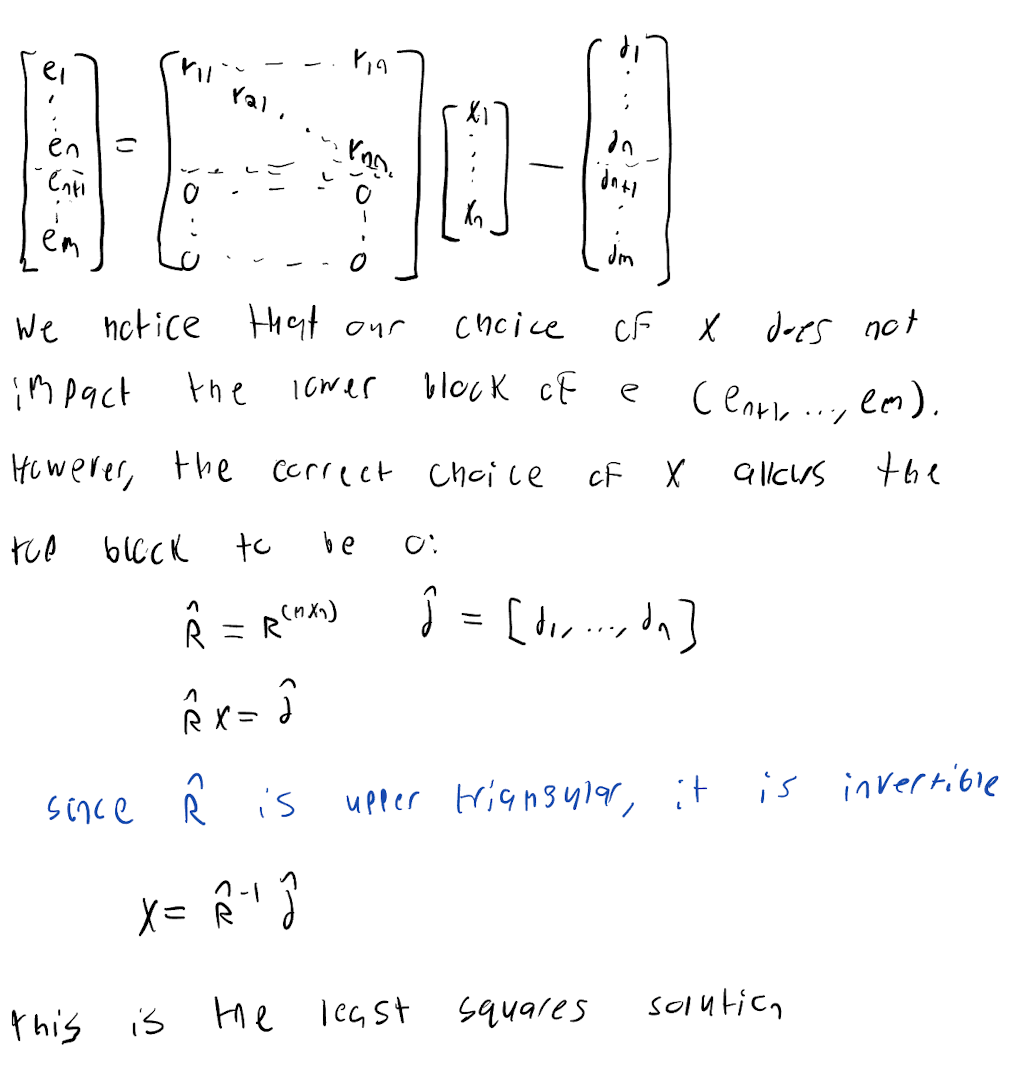